In [1]:
import torch
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mindf\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Load csv
BLOOD_DATASET_D1 = pd.read_csv(r'DATASETS\BLOOD\BLOOD_WBCELLS_HEMO_(D1).csv')

In [3]:
BLOOD_DATASET_D1.head

<bound method NDFrame.head of      gender  hematocrit       RBC        MCH         MCV        RDW  \
0         1   26.272727  2.960000  28.250000   89.900000  16.220000   
1         2   27.700000  2.620000  34.320000  109.800000  23.820000   
2         2   36.637500  4.277500  26.062500   85.625000  17.037500   
3         1   27.333333  3.235000  26.566667   84.500000  16.516667   
4         1   28.937500  3.720000  24.337500   77.875000  17.400000   
..      ...         ...       ...        ...         ...        ...   
913       1   33.628571  3.685714  27.842857   91.142857  15.557143   
914       1   28.715789  3.270000  29.772727   89.545455  18.672727   
915       2   27.685714  3.065714  26.900000   90.285714  17.285714   
916       2   33.537500  3.446250  31.150000   97.375000  16.000000   
917       1   29.937500  2.797143  36.771429  106.571429  16.157143   

     Leucocyte   Platelets  Neutrophils  Basophils  Lymphocyte  Creatinine  \
0     7.650000  305.100000        74.65

In [4]:
#Create dictionary of ideal values for each score; calculate L2 norm to generate score)
IDEAL_VALS = {'hematocrit': {'male': 45.5, 'female': 42}, 'RBC': {'male': 5.4, 'female': 4.8}, 'MCH': {'male': 29, 'female': 29}, "MCV": {'male': 30.5, 'female': 29.5}, 
              'RDW': {'male': 13.5, 'female': 13.5}, 'Leucocyte': {'male': 7.2, 'female': 7.2}, "Platelets": {'male': 240, 'female': 240}, 
              'Neutrophils': {'male': 50, 'female': 50}, 'Basophils': {'male': 0.75, 'female': 0.75}, 'Lymphocyte': {'male': 20, 'female': 20}, 
              'Creatinine': {'male': 1, 'female': 1.1}, 'Blood potassium': {'male': 4.4, 'female': 4.4}, 
              'Blood sodium': {'male': 140, 'female': 140}, 'Chloride': {'male': 102.5, 'female': 102.5}}
columns = BLOOD_DATASET_D1.columns.values.tolist()
#Generate scores for each lever - compare iteratively and generate average score on its basis
def generate_score(row):
    #Iterate over each column except for gender
    print(" =================================== ")
    total_score = 0
    for column in columns:
        if column == "gender" or column == "SCORE": continue
        #Check gender
        if row['gender'] == 1:
            #Compute absolute value between the current value of the column and the recommended value
            column_score = abs(row[column] - IDEAL_VALS[column]['male'])
            # print('COLUMN: ', column)
            # print('COLUMN SCORE: ', column_score)
            # print('COLUMN VALUE: ', row[column])
            # print('IDEAL VALUE: ', IDEAL_VALS[column]['male'])
        else:
            column_score = abs(row[column] - IDEAL_VALS[column]['female'])
            # print('COLUMN: ', column)
            # print('COLUMN SCORE: ', column_score)
            # print('COLUMN VALUE: ', row[column])
            # print('IDEAL VALUE: ', IDEAL_VALS[column]['male'])
        total_score += column_score
        
    #Average out the score
    row["SCORE"] = total_score / len(columns)
    print('END SCORE: ', row["SCORE"])
    return row

BLOOD_DATASET_D1 = BLOOD_DATASET_D1.apply(generate_score, axis = "columns")

END SCORE:  11.942433714375003
END SCORE:  11.1879910731875
END SCORE:  8.968199404812498
END SCORE:  10.7553645835625
END SCORE:  13.935729166687505
END SCORE:  13.4867317934375
END SCORE:  11.173489583374998
END SCORE:  13.288053188437502
END SCORE:  28.44234375
END SCORE:  9.869160712625
END SCORE:  9.296363097062503
END SCORE:  14.082922077
END SCORE:  10.681592951062498
END SCORE:  20.733541667562495
END SCORE:  10.670213069874997
END SCORE:  12.396668655125001
END SCORE:  10.004084765250001
END SCORE:  15.995479911937498
END SCORE:  8.7115000041875
END SCORE:  13.927085323375
END SCORE:  12.871439639625002
END SCORE:  11.554971595437502
END SCORE:  9.942295611875002
END SCORE:  12.0970833351875
END SCORE:  9.536795631937501
END SCORE:  8.5225094700625
END SCORE:  12.140089288125
END SCORE:  13.322363786187502
END SCORE:  12.538671874999999
END SCORE:  16.610364587499998
END SCORE:  11.219192708125
END SCORE:  12.9051562510625
END SCORE:  5.6486302083124995
END SCORE:  7.458437499

In [96]:
BLOOD_DATASET_D1.to_pickle('PREPROCESSED_BLOOD_D1_DATASET.pkl')

In [5]:
#Reshape tensors for XGBOOST
import tensorflow as tf
from sklearn.model_selection import train_test_split

x_features = BLOOD_DATASET_D1.iloc[:, 1:15]
y_labels = BLOOD_DATASET_D1["SCORE"]
train_x, valid_x, train_y, valid_y = train_test_split(x_features, y_labels, random_state = 2, shuffle = True)

train_x = tf.convert_to_tensor(train_x)
train_x = tf.reshape(train_x, [len(train_x), 14])

valid_x = tf.convert_to_tensor(valid_x)
valid_x = tf.reshape(valid_x, [len(valid_x), 14])

train_y = tf.convert_to_tensor(train_y)
train_y = tf.reshape(train_y, [len(train_y), 1])

valid_y = tf.convert_to_tensor(valid_y)
valid_y = tf.reshape(valid_y, [len(valid_y), 1])

In [6]:
#TRAIN GRADIENT BOOSTED TREE
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Convert to Dmatrix
TRAIN_DATA = xgb.DMatrix(train_x, train_y, feature_names = columns[1:15])
VALID_DATA = xgb.DMatrix(valid_x, valid_y, feature_names = columns[1:15])
#Parameters for boosted tree
XGBOOST_PARAMS = {"objective": "reg:squarederror", "subsample": 0.6,
                  "colsample_bytree" : 0.6, "learning_rate" : 0.1, "max_depth" : 100,
                  "alpha": 20, "n_estimators": 12}
#Train the xgboost model
# XGB_BLOOD_MODEL = xgb.XGBRegressor()
# XGB_BLOOD_MODEL.fit(train_x, train_y)
XGB_BLOOD_MODEL = xgb.train(XGBOOST_PARAMS, TRAIN_DATA, evals = [(TRAIN_DATA, "TRAIN_DATA"), (VALID_DATA, "VALID_DATA")],
                            num_boost_round = 200, early_stopping_rounds = 40)
predictions = XGB_BLOOD_MODEL.predict(VALID_DATA)
error = mean_squared_error(valid_y, predictions)
print('ERROR: ', error)

[07:19:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	TRAIN_DATA-rmse:12.81229	VALID_DATA-rmse:12.12894
[1]	TRAIN_DATA-rmse:11.75022	VALID_DATA-rmse:11.04232
[2]	TRAIN_DATA-rmse:10.73744	VALID_DATA-rmse:10.05028
[3]	TRAIN_DATA-rmse:9.79794	VALID_DATA-rmse:9.12993
[4]	TRAIN_DATA-rmse:8.97348	VALID_DATA-rmse:8.32236
[5]	TRAIN_DATA-rmse:8.19311	VALID_DATA-rmse:7.57078
[6]	TRAIN_DATA-rmse:7.58328	VALID_DATA-rmse:6.96329
[7]	TRAIN_DATA-rmse:7.02221	VALID_DATA-rmse:6.39212
[8]	TRAIN_DATA-rmse:6.56486	VALID_DATA-rmse:5.92131
[9]	TRAIN_DATA-rmse:6.03059	VALID_DATA-rmse:5.40248
[10]	TRAIN_DATA-rmse:5.66479	VALID_D

In [7]:
#Save Model
XGB_BLOOD_MODEL.save_model('REPORTS_BLOOD_GRADBOOSTED_MODELS[1.5].model')

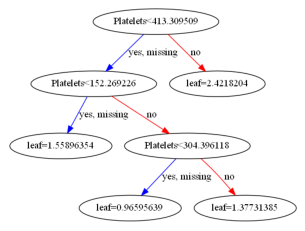

In [7]:
# #Print desicion tree -> transparency into exactly what the model is doing
xgb.plot_tree(XGB_BLOOD_MODEL, num_trees = 0)
plt.rcParams['figure.figsize'] = [1920, 1080]
plt.show()